In [1]:
from numpy import loadtxt
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, log_loss, make_scorer
import numpy as np
import pandas as pd
import multiprocessing
import concurrent.futures
import uproot
import collections
import matplotlib.pyplot as plt
import pickle
import copy
import math

In [2]:
Tree = uproot.open("/data/atlas/atlasdata3/ambroz/VHbb/FSRandSoftMETnTausntuples.root")["Nominal"]

In [3]:
DataFrame = Tree.pandas.df(["nJ", 
                            "EventWeight", "EventNumber", "nTags",
                            "mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "dEtaBB", "MEff", "mBBJ", "pTJ3",
                            "bin_MV2c10B1", "bin_MV2c10B2",
                            "nTaus",
                            "softMET",
                            "dRBBJ",
                            "sample"])

In [4]:
 DataFrame = DataFrame[ (DataFrame["sample"] != b'data')
                   &   (DataFrame["sample"] != b'qqZvvH125cc') 
                   &   (DataFrame["sample"] != b'qqWlvH125cc')
                   &   (DataFrame["sample"] != b'qqZllH125cc')
                   &   (DataFrame["sample"] != b'ggZvvH125cc')
                   &   (DataFrame["sample"] != b'ggZllH125cc')
                   &   (DataFrame["nTags"]  == 2)
                   &   (DataFrame["nJ"] < 4) ]

In [5]:
%load_ext Cython

In [6]:
%%cython 
def assign_class(object sample):
    
    #Class 1: signal
    if sample == b'qqZvvH125':
        return 1
    if sample == b'ggZvvH125':
        return 1
    if sample == b'qqZllH125':
        return 1
    if sample == b'ggZllH125':
        return 1
    if sample == b'qqWlvH125':
        return 1
    
    
    return 0

In [7]:
DataFrame['Class'] = DataFrame.apply(lambda row: assign_class(row["sample"]), axis=1)

In [8]:
DataFrame[DataFrame["Class"] == 1].head()

nJ   EventWeight  EventNumber  nTags         mBB      dRBB  \
15490705   3  8.431755e-07         2983      2   69.191132  1.089134   
15490707   2  1.106429e-05         5018      2  166.333069  1.985770   
15490713   3  6.913893e-07         6323      2  235.420456  1.957240   
15490716   3  9.969540e-07         7395      2  134.799194  1.653088   
15490717   2  3.481138e-04         8710      2  110.736923  1.037500   

                pTB1       pTB2         MET   dPhiVBB  ...        MEff  \
15490705   94.322311  41.474815  160.383591  2.995171  ...  336.646912   
15490707  176.415237  33.175076  168.201172  3.114816  ...  377.791473   
15490713  203.794968  54.116051  150.801300  2.851730  ...  492.709869   
15490716  162.732300  49.202591  166.875534  3.053922  ...  407.847168   
15490717  111.478523  90.056732  153.066940  3.109953  ...  354.602203   

                mBBJ       pTJ3  bin_MV2c10B1  bin_MV2c10B2  nTaus    softMET  \
15490705  143.947617  40.466187           5.0           4.0      0  19.326937   
15490707  166.333069   0.000000           4.0           4.0      0  26.252598   
15490713  340.516815  83.997566           5.0           4.0      1  27.486595   
15490716  199.342834  29.036734           5.0           5.0      0  21.936085   
15490717  110.736923   0.000000           5.0           5.0      0  31.116608   

             dRBBJ        sample Class  
15490705  1.596941  b'ggZllH125'     1  
15490707  2.475312  b'ggZllH125'     1  
15490713  1.608248  b'ggZllH125'     1  
15490716  1.840384  b'ggZllH125'     1  
15490717  1.598937  b'ggZllH125'     1  

[5 rows x 21 columns]

In [9]:
DataFrame2jet = DataFrame[DataFrame["nJ"] == 2]
DataFrame3jet = DataFrame[DataFrame["nJ"] == 3]
DataFrame2jet = DataFrame2jet.drop("nJ",axis=1)
DataFrame3jet = DataFrame3jet.drop("nJ",axis=1)

In [10]:
DataFrame2jet.head()

EventWeight  EventNumber  nTags         mBB      dRBB        pTB1  \
2      0.000021     74444653      2   45.017841  0.658432  138.601883   
7      0.000016     74112605      2  160.776993  1.798051   86.029137   
10     0.000018     74139179      2   89.507851  0.913468  122.576881   
11     0.000008     74170024      2   47.553169  0.508480  119.919189   
12     0.000019     74141224      2  124.542442  1.918412  136.219833   

         pTB2         MET   dPhiVBB    dEtaBB        MEff        mBBJ  pTJ3  \
2   28.851734  154.746170  3.073225  0.332678  322.199799   45.017841   0.0   
7   69.878517  157.099365  3.063205  1.795710  313.007019  160.776993   0.0   
10  75.785561  193.099167  3.112830  0.120047  391.461609   89.507851   0.0   
11  45.301308  158.818359  3.101176  0.007250  324.038849   47.553169   0.0   
12  26.430521  150.799362  3.091295  1.614361  313.449707  124.542442   0.0   

    bin_MV2c10B1  bin_MV2c10B2  nTaus    softMET     dRBBJ sample  Class  
2            4.0           4.0      0  13.671432  2.141544  b'Wl'      0  
7            4.0           5.0      0  12.429815  2.943405  b'Wl'      0  
10           5.0           4.0      0  14.894521  2.051464  b'Wl'      0  
11           4.0           4.0      0   5.322830  1.332099  b'Wl'      0  
12           4.0           4.0      0   4.660871  2.446287  b'Wl'      0

In [11]:
DataFrame2jet_150_250 = DataFrame2jet[DataFrame2jet["MET"] < 250]
DataFrame3jet_150_250 = DataFrame3jet[DataFrame3jet["MET"] < 250]

In [12]:
DataFrame2jet_250 = DataFrame2jet[DataFrame2jet["MET"] > 250]
DataFrame3jet_250 = DataFrame3jet[DataFrame3jet["MET"] > 250]

In [13]:
DataFrames = {
    '2jet_150_250' : DataFrame2jet_150_250,
    '2jet_250'     : DataFrame2jet_250,
    '3jet_150_250' : DataFrame3jet_150_250,
    '3jet_250'    : DataFrame3jet_250,
}

In [14]:
list(DataFrames.keys())

['2jet_150_250', '2jet_250', '3jet_150_250', '3jet_250']

In [15]:
model_path = "/data/atlas/atlasdata3/ambroz/VHbb/Models/HybridAbsFSR/"

In [16]:
def addTrainingToDataFrame(model, dataframe, feature_names, training_name):
    
    model_fold1 = pickle.load(open(model + "_fold1.dat", "rb"))
    model_fold2 = pickle.load(open(model + "_fold2.dat", "rb"))
    
    if len(feature_names) != len(list(model_fold1.feature_importances_)):
        print("Feature mismatch!")
    
    DataFrame_test_fold1 = copy.deepcopy(dataframe[(dataframe['EventNumber'] % 2) == 1]) #Odd
    DataFrame_test_fold2 = copy.deepcopy(dataframe[(dataframe['EventNumber'] % 2) == 0]) #Even
    
    Y_test_predictions_proba_fold1 = model_fold1.predict_proba(DataFrame_test_fold1[feature_names].values, ntree_limit=model_fold1.best_ntree_limit)
    Y_test_predictions_proba_fold2 = model_fold2.predict_proba(DataFrame_test_fold2[feature_names].values, ntree_limit=model_fold2.best_ntree_limit)
    
    #plot_tree(model_fold1, num_trees=0, rankdir='LR')
    
    Signal_test_predictions_proba_fold1 = Y_test_predictions_proba_fold1[:,1].tolist() #Get the column 1, for the signal
    Signal_test_predictions_proba_fold2 = Y_test_predictions_proba_fold2[:,1].tolist() #Get the column 1, for the signal
    
    DataFrame_test_fold1[training_name] =  Signal_test_predictions_proba_fold1
    DataFrame_test_fold2[training_name] =  Signal_test_predictions_proba_fold2
    
    DataFrame_test_fold12 = pd.concat([DataFrame_test_fold1, DataFrame_test_fold2], ignore_index = True)
    
    return DataFrame_test_fold12

In [17]:
vars2j = {
    '0054' : ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "dEtaBB", "MEff"],
    '0053' : ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "dEtaBB", "MEff", "bin_MV2c10B1", "bin_MV2c10B2"],
    '0052' : ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB"],
    '0051' : ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "dEtaBB", "MEff", "nTaus"],
    '005'  : ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "dEtaBB", "MEff"],
    '0049' : ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "dEtaBB", "MEff", "softMET"],
    '0048' : ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "softMET", "nTaus", "bin_MV2c10B1", "bin_MV2c10B2"],
}

namesTraining = {
    '0054' : "Default_",
    '0053' : "PCBT_",
    '0052' : "NoMEffanddEtaBB_",
    '0051' : "nTaus_",
    '005'  : "dRBBJ_",
    '0049' : "softMET_",
    '0048' : "All_",
}

for region in DataFrames.keys():
    
    print(region)
    
    for nameTraining in namesTraining.keys():
    
        print(nameTraining)
    
        ptv = '250'
        if '150' in region:
            ptv = '150_250'
    
        variables = copy.deepcopy(vars2j[nameTraining])
        nJ = "2"
        if '3jet' in region:
            nJ = "3"
            variables.append("mBBJ")
            variables.append("pTJ3")
            if namesTraining[nameTraining] == "dRBBJ_" or namesTraining[nameTraining] == "All_":
                variables.append("dRBBJ")
        
    
        print(variables)
        DataFrames[region] = addTrainingToDataFrame(model_path + "training_VH_model_XGB_logloss_max_depth5_learning_rate" + nameTraining + "_ZeroLepton_jets" + nJ + "_ptv_" + ptv,
                                                    DataFrames[region],
                                                    variables,
                                                    namesTraining[nameTraining])
    
        print("==========")

2jet_150_250
0054
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff']
0053
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff', 'bin_MV2c10B1', 'bin_MV2c10B2']
0052
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB']
0051
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff', 'nTaus']
005
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff']
0049
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff', 'softMET']
0048
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'softMET', 'nTaus', 'bin_MV2c10B1', 'bin_MV2c10B2']
2jet_250
0054
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff']
0053
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff', 'bin_MV2c10B1', 'bin_MV2c10B2']
0052
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB']
0051
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff', 'nTaus']
005
['mBB', 'dRBB', 'pTB1', 'pTB2', 'MET', 'dPhiVBB', 'dEtaBB', 'MEff']
0049
['mBB', 

In [18]:
DataFrames['3jet_250'].head()

EventWeight  EventNumber  nTags         mBB      dRBB        pTB1  \
0     0.000062     75559673      2  190.687134  2.275099  285.794067   
1    -0.000045     71327553      2  115.117996  2.303221   92.159470   
2    -0.000585       696457      2  184.242905  2.141999  259.684998   
3     0.000004      1702335      2  512.257141  2.678961  240.992416   
4     0.000010      1376807      2  120.591850  1.292218  294.364319   

         pTB2         MET   dPhiVBB    dEtaBB  ...     dRBBJ  sample  Class  \
0   38.263294  277.809509  2.784369  0.013467  ...  2.326791   b'Wl'      0   
1   25.409252  288.205566  3.083105  1.688170  ...  1.345050   b'Wl'      0   
2   30.857716  259.870941  3.108836  1.185732  ...  0.487603  b'Wbl'      0   
3  111.375763  258.181488  2.997664  2.292321  ...  2.311807   b'Wl'      0   
4   32.559540  290.304199  3.061315  0.040651  ...  2.199065   b'Wl'      0   

   Default_     PCBT_  NoMEffanddEtaBB_    nTaus_    dRBBJ_  softMET_  \
0  0.035318  0.037922          0.043679  0.051445  0.041788  0.033200   
1  0.326824  0.207670          0.280450  0.301570  0.344277  0.289732   
2  0.064954  0.056144          0.058646  0.063346  0.058282  0.055005   
3  0.058903  0.050262          0.062064  0.069394  0.065211  0.092726   
4  0.810742  0.731688          0.803253  0.823449  0.831964  0.823534   

       All_  
0  0.045992  
1  0.260691  
2  0.051194  
3  0.058505  
4  0.784166  

[5 rows x 27 columns]

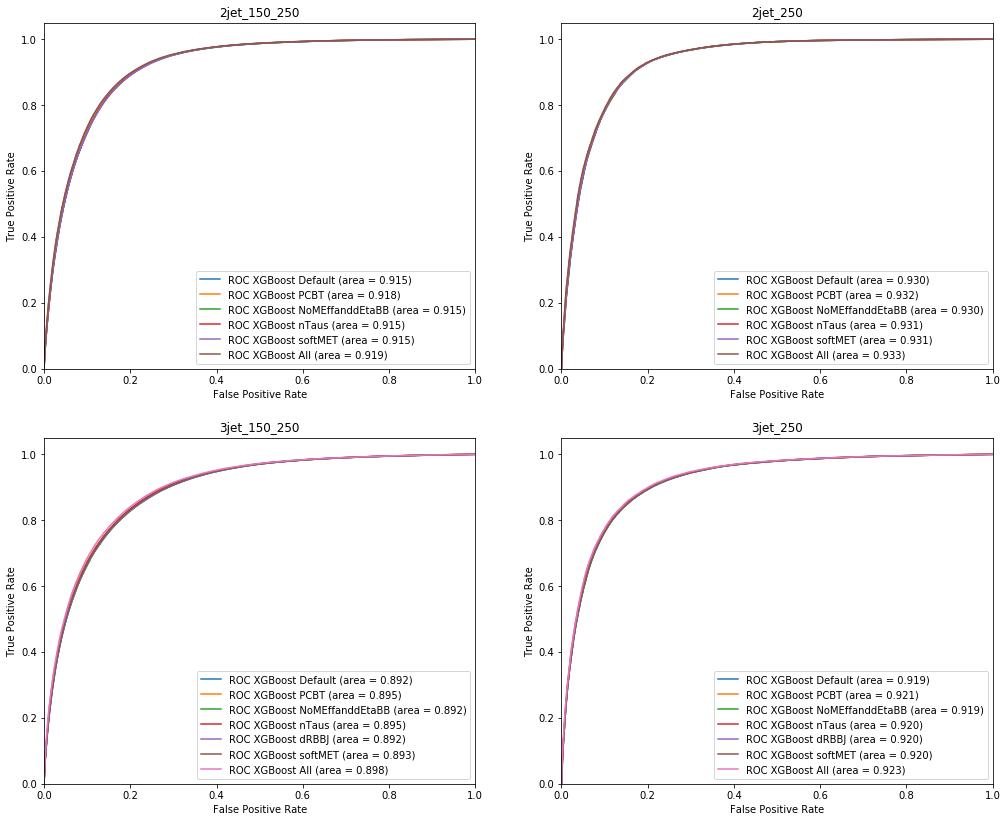

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(17, 14)) 
axes = axes.ravel()

for i, region in enumerate(list(DataFrames.keys())):
        
    plt.sca(axes[i])
    
    roc_auc_XGBoost = {}
    fpr_XGBoost = {}
    tpr_XGBoost = {}
    
    for nameTraining in namesTraining.values():
        
        if "2j" in region and nameTraining == "dRBBJ_":
            continue
        
        fpr_XGBoost[nameTraining], tpr_XGBoost[nameTraining], _ = roc_curve(DataFrames[region]['Class'], DataFrames[region][nameTraining],  sample_weight = abs(DataFrames[region]['EventWeight']))
        roc_auc_XGBoost[nameTraining] = auc(fpr_XGBoost[nameTraining], tpr_XGBoost[nameTraining])
        plt.plot(fpr_XGBoost[nameTraining], tpr_XGBoost[nameTraining], label = 'ROC XGBoost ' + nameTraining.replace("_","") + ' (area = %0.3f)' % roc_auc_XGBoost[nameTraining])
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(region)
    plt.legend(loc="lower right")

In [20]:
def compute_significance(hist_s, hist_bkg): 
    
    rad = 0
    for ns_i, nb_i in zip(hist_s, hist_bkg):
        if ns_i < 0.00001:
            continue
        rad += (ns_i + nb_i)*math.log(1+ ns_i / nb_i) - ns_i

    S = math.sqrt(2*rad)
    
    return S

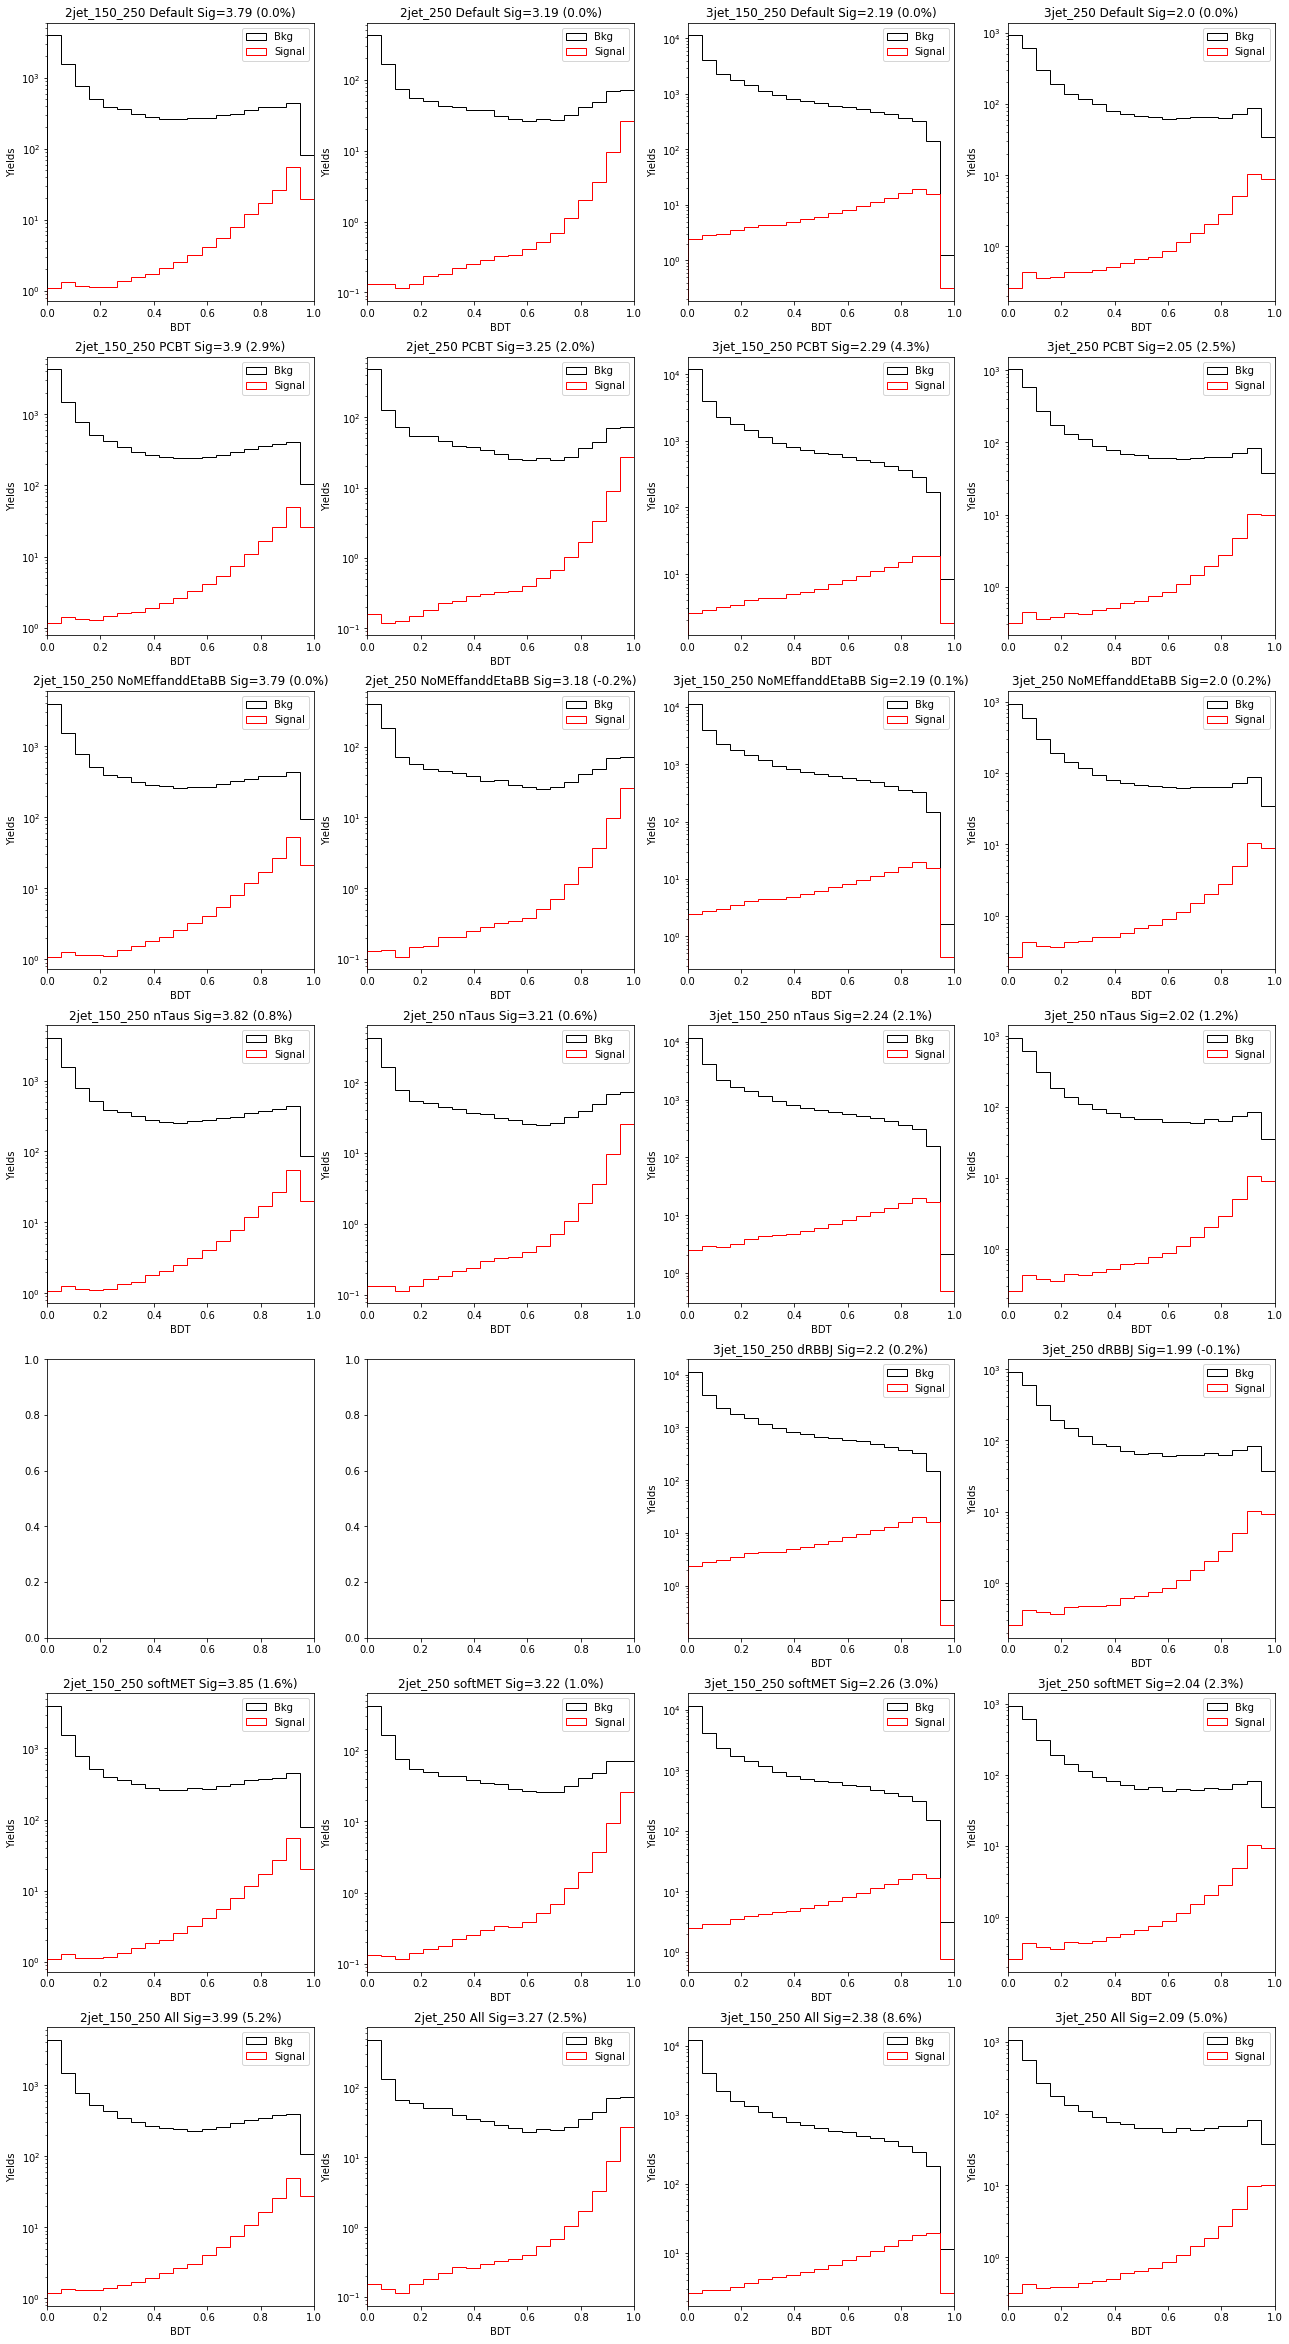

In [27]:
fig, axes = plt.subplots(7, 4, figsize=(22, 42)) 
axes = axes.ravel()

j = 0
sig_default = {}
for nameTraining in namesTraining.values():
    
    for i, region in enumerate(list(DataFrames.keys())):
        
        plt.sca(axes[j])
        
        if "2j" in region and nameTraining == "dRBBJ_":
            j+=1
            continue
        
        Signal = DataFrames[region][(DataFrames[region]["Class"] == 1)]
        Bkg = DataFrames[region][(DataFrames[region]["Class"] == 0)]
        
        bins = np.linspace(0, 1, 20)
                                 
        (n, bins, patches) = plt.hist([Signal[nameTraining], Bkg[nameTraining]], 
                                       bins, 
                                       weights = [Signal["EventWeight"], Bkg["EventWeight"]], 
                                       color = ['red', 'black'],
                                       ###Hist type###
                                       histtype = 'step', 
                                       density = False,
                                       ###############
                                       label = ['Signal', 'Bkg'],
            )
        
        
        sig = compute_significance(n[0], n[1])
        
        if nameTraining == "Default_":
            sig_default[region] = sig
                
        plt.xlim([0, 1.0])
        plt.yscale('log')
        plt.xlabel('BDT')
        plt.ylabel('Yields')
        imp = round( (sig-sig_default[region]) / sig_default[region] * 100, 1)
    
        plt.title(region + ' ' + nameTraining.replace("_","") + ' Sig=' + str(round(sig,2)) + ' (' + str(imp) + '%)')
        plt.legend(loc="upper right")
        
        j+=1
        
fig.savefig('BDT.pdf')